In [1]:
import functools
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from tqdm.auto import trange

sys.path.append("..")


from kuramoto.approximator import KuramotoApproximator
from kuramoto.plot import plot_image
from kuramoto.trajectory import (IsDivergingPrecise, compare_trajectory,
                                 get_order_parameter)
from neural_rk import fitting
from neural_rk.hyperparameter import HyperParameter
from neural_rk.modules import RungeKutta, prune_state_dict
from neural_rk.path import DATA_DIR, FIG_DIR, RESULT_DIR
from neural_rk.scheduler import get_scheduler
from neural_rk.trainer import rollout

In [6]:
device = torch.device("cuda:1")
exp_id = "A"
test_id = "A_test"

result_dir = RESULT_DIR / f"kuramoto_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load data
test_df = pd.read_pickle(DATA_DIR / f"kuramoto_{test_id}.pkl")

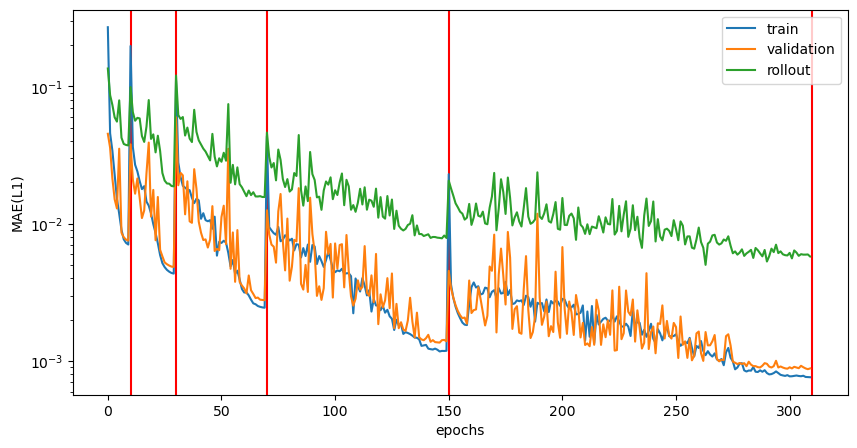

In [7]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

In [8]:
approximator = KuramotoApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
# model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

kuramoto_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)


# Rollout

In [9]:
pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(kuramoto_rollout(series=test_df.iloc[idx]).cpu().numpy())


  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
    pickle.dump(pred_trajectories, f)

# with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
#     pred_trajectories = pickle.load(f)

# Analyze

In [11]:
times = np.array(
    [np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts],
    dtype=np.float32,
)
true_trajectories = [traj.numpy() for traj in test_df.trajectories]

maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # (# of samples, S)
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, rr, N=130 MAE=0.0080, Maximum err: 0.0929 at step=391, node=122
idx=1, rr, N=70 MAE=0.0068, Maximum err: 0.1226 at step=455, node=68
idx=2, er, N=55 MAE=0.0072, Maximum err: 0.0810 at step=418, node=40
idx=3, ba, N=135 MAE=0.0141, Maximum err: 0.4409 at step=456, node=116
idx=4, rr, N=52 MAE=0.0157, Maximum err: 1.0041 at step=443, node=35
idx=5, er, N=138 MAE=0.0199, Maximum err: 1.1053 at step=484, node=66
idx=6, ba, N=121 MAE=0.0086, Maximum err: 0.1023 at step=324, node=4
idx=7, ba, N=51 MAE=0.0133, Maximum err: 0.1628 at step=433, node=18
idx=8, er, N=143 MAE=0.0084, Maximum err: 0.1292 at step=500, node=123
idx=9, rr, N=95 MAE=0.0064, Maximum err: 0.0476 at step=297, node=94
idx=10, er, N=137 MAE=0.0073, Maximum err: 0.0995 at step=470, node=122
idx=11, rr, N=134 MAE=0.0093, Maximum err: 0.1940 at step=500, node=70
idx=12, rr, N=66 MAE=0.0068, Maximum err: 0.0476 at step=264, node=19
idx=13, ba, N=79 MAE=0.0077, Maximum err: 0.0915 at step=486, node=74
idx=14, ba, N=59 MAE

## Single sample

In [34]:
sample_idx = 5

print(test_df.network_type[sample_idx])
xticks = np.round(np.linspace(0, times[sample_idx, -1], 5), 2)
true_trajcetory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]
error = true_trajcetory - pred_trajectory

print(f"{error.min() / np.pi:.2f}pi < error < {error.max() / np.pi:.2f}pi")

er
-0.35pi < error < 0.24pi


plot node with index: [ 96 100  62 103 108  93  26  50  61  47]


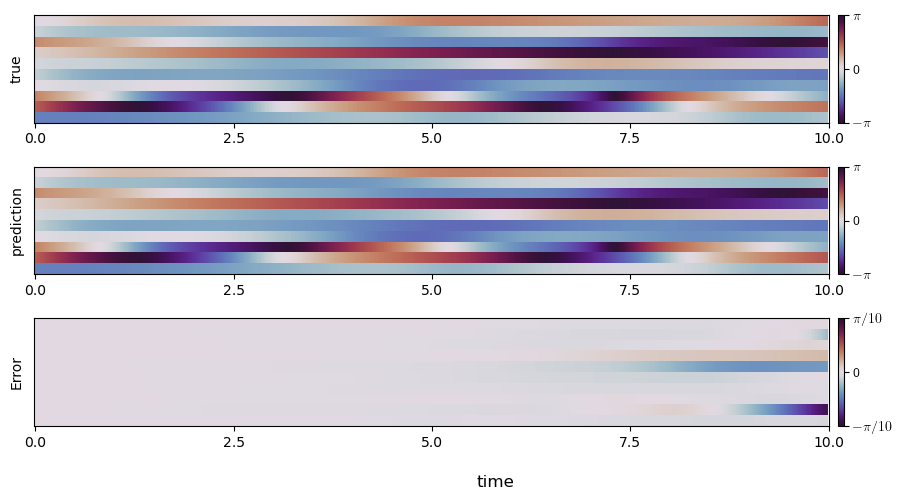

In [36]:
nodes = np.random.choice(np.arange(true_trajcetory.shape[1]), 10, replace=False)
# nodes = set()
# for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:   # max
# # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()):   # min
#     idx = np.unravel_index(idx, error.shape[1:])
#     nodes.add(idx[0])
#     if len(nodes) == 10:
#         break
nodes = np.array(list(nodes))
print(f"plot node with index: {nodes}")

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)
ax1.set_ylabel("true")
im = plot_image(
    ax1,
    true_trajcetory,
    nodes,
    xticks=xticks,
)
cbar = fig.colorbar(im, ax=ax1, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi])
cbar.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)

ax2.set_ylabel("prediction")
im = plot_image(
    ax2,
    pred_trajectory,
    nodes,
    xticks=xticks,
)
cbar = fig.colorbar(im, ax=ax2, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi])
cbar.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)

ax3.set_ylabel("Error")
im = plot_image(
    ax3,
    error,
    nodes,
    lim=(-0.1 * np.pi, 0.1 * np.pi),
    xticks=xticks,
)
cbar = fig.colorbar(
    im,
    ax=ax3,
    location="right",
    pad=0.01,
    ticks=[-0.1 * np.pi, 0, 0.1 * np.pi]
)
# cbar.ax.set_yticklabels([r"$-\pi/100$", 0, r"$\pi/100$"], usetex=True)
cbar.ax.set_yticklabels([r"$-\pi/10$", 0, r"$\pi/10$"], usetex=True)

fig.supxlabel("time")
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/kuramoto_trajectory.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()

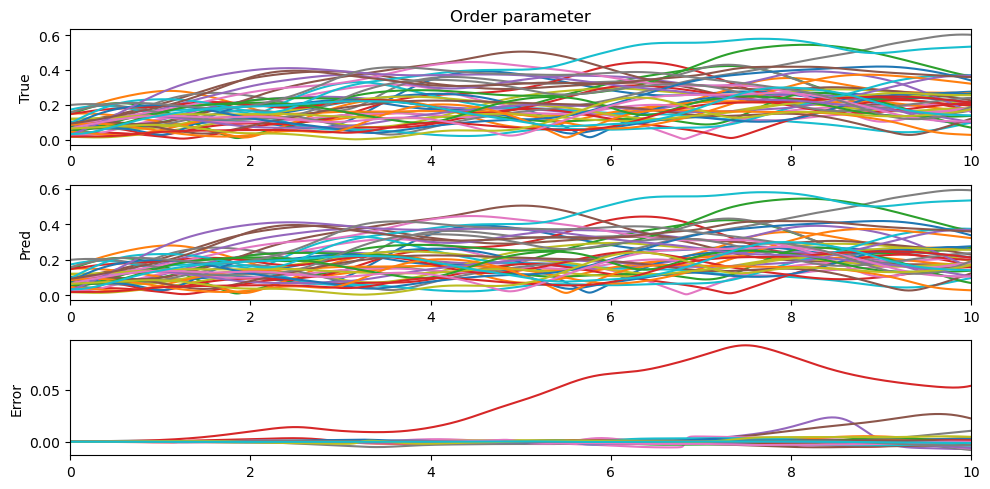

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

for t, true_traj, pred_traj in zip(times, true_trajectories, pred_trajectories):
    true_op, pred_op = get_order_parameter(true_traj), get_order_parameter(pred_traj)
    ax1.plot(t, true_op)
    ax2.plot(t, pred_op)
    ax3.plot(t, true_op - pred_op)

ax1.set_xlim(0.0, 10.0)
ax1.set_ylabel("True")
ax1.set_title("Order parameter")
ax2.set_xlim(0.0, 10.0)
ax2.set_ylabel("Pred")
ax3.set_xlim(0.0, 10.0)
ax3.set_ylabel("Error")


fig.tight_layout()
fig.show()

## Statisics over samples

slope: 0.0781 pm 0.0291
slope of averaged curve: 0.0996


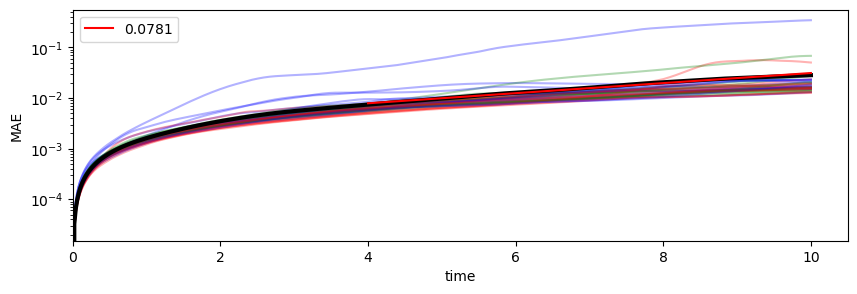

In [40]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 4.0, "log"

fig, ax = plt.subplots(figsize=(10, 3))

slopes = []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, maes):
    # ax.plot(sample_time, sample_mae, color="gray", alpha=0.3)
    ax.plot(sample_time, sample_mae, color=colors[network_type], alpha=0.3)

    mask = sample_time > fit_range
    if yscale == "log":
        *_, slope, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask])
    else:
        *_, slope, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask])
    slopes.append(slope)


final_mae = np.mean(maes, 0)
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
ax.plot(t, final_mae, "k-", linewidth=3)

mask = t > fit_range
if yscale == "log":
    fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
else:
    fit_t, fit_mae, slope, _ = fitting.lin_fit(t[mask], final_mae[mask])
print(f"slope: {np.mean(slopes):.4f} pm {np.std(slopes):.4f}")
print(f"slope of averaged curve: {slope:.4f}")
ax.plot(fit_t, fit_mae, "r-", label=f"{np.mean(slopes):.4f}")
ax.legend()

if yscale == "log":
    ax.set_yscale("log")
ax.set_xlim(left=0)
ax.set_xlabel("time")
ax.set_ylabel("MAE")
# fig.savefig(f"{FIG_DIR}/kuramoto_mae.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()